# Heart Attack Dataset - Exploratory Data Analysis

This notebook performs an end-to-end EDA to understand the dataset, assess data quality, explore distributions, visualize relationships, and compute correlations.

- Dataset path: `src/data/Heart_Attack.csv`
- Goals:
  - Detect missing data, duplicates, and outliers
  - Understand distributions of continuous variables
  - Summarize categorical variables
  - Visualize relationships (histograms, density, bar charts, boxplots)
  - Correlation analysis with heatmap


### Imports and Settings — Explanation
- **What this does**: Imports core libraries (pandas, numpy, seaborn, matplotlib) and sets plotting/display preferences. Defines the dataset path and target column name. Includes a helper to classify columns.
- **Why it matters**: Ensures a consistent, reproducible analysis environment and prepares utilities used throughout the EDA. Column classification enables correct statistical summaries and visualizations.
- **Notes to summarize after running**:
  - Confirm `DATA_PATH` and `TARGET_COL` are correct for this dataset.
  - Adjust styling or figure sizes if needed for the report.


In [123]:
# Imports and settings
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 120)

# Plotting style
sns.set_theme(style='whitegrid', context='notebook', palette='Set2')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

DATA_PATH = './src/data/Heart_Attack.csv'
TARGET_COL = 'target'  # update if different in your dataset

# Helper: classify columns by dtype and cardinality
def detect_column_types(df: pd.DataFrame, target_col: str | None = None, cat_max_unique: int = 10):
    cont_cols = []
    cat_cols = []
    for col in df.columns:
        if col == target_col:
            continue
        if pd.api.types.is_numeric_dtype(df[col]):
            # numeric but low unique count -> treat as categorical (e.g., codes)
            if df[col].nunique(dropna=True) <= cat_max_unique:
                cat_cols.append(col)
            else:
                cont_cols.append(col)
        else:
            cat_cols.append(col)
    return cont_cols, cat_cols



### Data Loading and Preview — Explanation
- **What this does**: Loads the dataset from disk, prints its shape, and displays the first rows.
- **Why it matters**: Validates file access and confirms that columns and data types match expectations before deeper analysis. Early sanity checks help catch path or formatting issues.
- **Notes to summarize after running**:
  - Shape: [fill]
  - Any immediate anomalies in header/types: [fill]


In [124]:
# Load dataset
assert os.path.exists(DATA_PATH), f"File not found: {DATA_PATH}"

df = pd.read_csv(DATA_PATH)
print(f"Shape: {df.shape}")
df.head()


Shape: (1763, 12)


,age,sex,Chest pain type,trestbps,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,70,1,4,130,322,0,2,109,0,2.4,2,2
1,67,0,3,115,564,0,2,160,0,1.6,2,1
2,57,1,2,124,261,0,0,141,0,0.3,1,2
3,64,1,4,128,263,0,0,105,1,0.2,2,1
4,74,0,2,120,269,0,2,121,1,0.2,1,1


### Missing Values and Duplicates — Explanation
- **What this does**: Reports missing-value counts and duplicate rows.
- **Why it matters**: Missingness patterns guide imputation strategies and can themselves be predictive (e.g., missing cholesterol could be systematic). Duplicates can bias distributions and model evaluation if not addressed.
- **Notes to summarize after running**:
  - Columns with non-zero missingness and their percentages: [fill]
  - Number of duplicates and chosen action (drop/keep with justification): [fill]


In [125]:
# Missing values and duplicates overview
missing_counts = df.isna().sum().sort_values(ascending=False)
missing_percentages = (missing_counts / len(df) * 100).round(2)
missing_table = pd.DataFrame({'missing_count': missing_counts, 'missing_percentage': missing_percentages})

print("Table of Missing Values per Column")
display(missing_table[missing_table['missing_count'] > 0])

Table of Missing Values per Column


,missing_count,missing_percentage


### Duplicated Rows — Explanation
- **What this does**: Lists all rows that are duplicates across all columns, including every copy of a duplicate group.
- **Why it matters**: Exact duplicates can bias statistics and model training if not removed. If found, consider dropping duplicates or investigating their source.


In [126]:
# Print all duplicated rows (all copies)
num_duplicates = df.duplicated().sum()
print(f"\nDuplicate rows: {num_duplicates}")

dupes_all = df[df.duplicated(keep=False)]
print(f"Total duplicate rows (all copies): {dupes_all.shape[0]}")
display(dupes_all)



Duplicate rows: 272
Total duplicate rows (all copies): 544


,age,sex,Chest pain type,trestbps,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
663,49,0,2,110,208,0,0,160,0,0.0,1,0
736,49,0,2,110,208,0,0,160,0,0.0,1,0
1129,58,1,3,150,219,0,1,118,1,0.0,2,1
1177,58,1,3,150,219,0,1,118,1,0.0,2,1
1190,70,1,4,130,322,0,2,109,0,2.4,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1729,42,1,3,130,180,0,0,150,0,0.0,1,0
1730,61,1,4,140,207,0,2,138,1,1.9,1,1
1731,66,1,4,160,228,0,2,138,0,2.3,1,0
1732,46,1,4,140,311,0,0,120,1,1.8,2,1


### Column Type Detection — Explanation
- **What this does**: Automatically categorizes features into continuous vs. categorical using data types and unique-value thresholds, excluding the `target`.
- **Why it matters**: Ensures subsequent analyses (stats, plots, encodings) use appropriate methods per feature type. Prevents misinterpreting numeric-coded categories as continuous.
- **Notes to summarize after running**:
  - Confirmed continuous columns: [fill]
  - Confirmed categorical columns: [fill]
  - Adjust `TARGET_COL` if needed.


In [127]:
# Detect column characteristics and dtypes
print("Columns:", list(df.columns))

# Infer column types
continuous_cols, categorical_cols = detect_column_types(df, target_col=TARGET_COL)

# If target column exists, move it out of categories if mistakenly included
if TARGET_COL in categorical_cols:
    categorical_cols = [c for c in categorical_cols if c != TARGET_COL]

print("\nContinuous columns:", continuous_cols)
print("Categorical columns:", categorical_cols)

# Quick sanity view of dtypes
df.dtypes


Columns: ['age', 'sex', 'Chest pain type', 'trestbps', 'cholesterol', 'fasting blood sugar', 'resting ecg', 'max heart rate', 'exercise angina', 'oldpeak', 'ST slope', 'target']

Continuous columns: ['age', 'trestbps', 'cholesterol', 'max heart rate', 'oldpeak']
Categorical columns: ['sex', 'Chest pain type', 'fasting blood sugar', 'resting ecg', 'exercise angina', 'ST slope']


age                      int64
sex                      int64
Chest pain type          int64
trestbps                 int64
cholesterol              int64
fasting blood sugar      int64
resting ecg              int64
max heart rate           int64
exercise angina          int64
oldpeak                float64
ST slope                 int64
target                   int64
dtype: object

### Descriptive Statistics for Continuous Variables — Explanation
- **What this does**: Computes central tendency and dispersion (mean, median, std, quartiles, min/max) for each continuous feature.
- **Why it matters**: Establishes baselines, detects scale differences (informing normalization/standardization), and highlights potential data quality issues (e.g., impossible min/max). These stats also help prioritize features for initial baselines vs. advanced models.
- **Notes to summarize after running**:
  - Variables with large mean–median gaps (skewed): [fill]
  - Features requiring scaling due to different ranges: [fill]


In [128]:
# Descriptive statistics for continuous variables
if len(continuous_cols) == 0:
    print("No continuous columns detected.")
else:
    desc = df[continuous_cols].describe().T
    # add additional stats
    desc['median'] = df[continuous_cols].median()
    desc['std'] = df[continuous_cols].std()
    desc = desc.rename(columns={'25%': 'q1', '50%': 'q2', '75%': 'q3'})
    display(desc[['count', 'mean', 'median', 'std', 'min', 'q1', 'q2', 'q3', 'max']])


,count,mean,median,std,min,q1,q2,q3,max
age,1763.0,53.952921,55.0,9.267101,28.0,47.0,55.0,61.0,77.0
trestbps,1763.0,131.950085,130.0,18.154333,0.0,120.0,130.0,140.0,200.0
cholesterol,1763.0,222.625638,234.0,90.119674,0.0,199.0,234.0,272.5,603.0
max heart rate,1763.0,142.952921,145.0,25.150727,60.0,125.0,145.0,162.0,202.0
oldpeak,1763.0,0.962337,0.6,1.109458,-2.6,0.0,0.6,1.6,6.2


### Histograms and KDE for Continuous Variables — Explanation
- **What this does**: Shows the distribution of each continuous feature with histograms and kernel density estimates (KDEs).
- **Why it matters**: Skewness, multimodality, and heavy tails guide preprocessing (e.g., log transforms), feature scaling, and suitability for algorithms. Understanding distributional shapes also helps interpret boxplot outliers and later model residuals.
- **Notes to summarize after running**:
  - Features with strong skewness or long tails: [fill]
  - Candidates for transformation or binning: [fill]


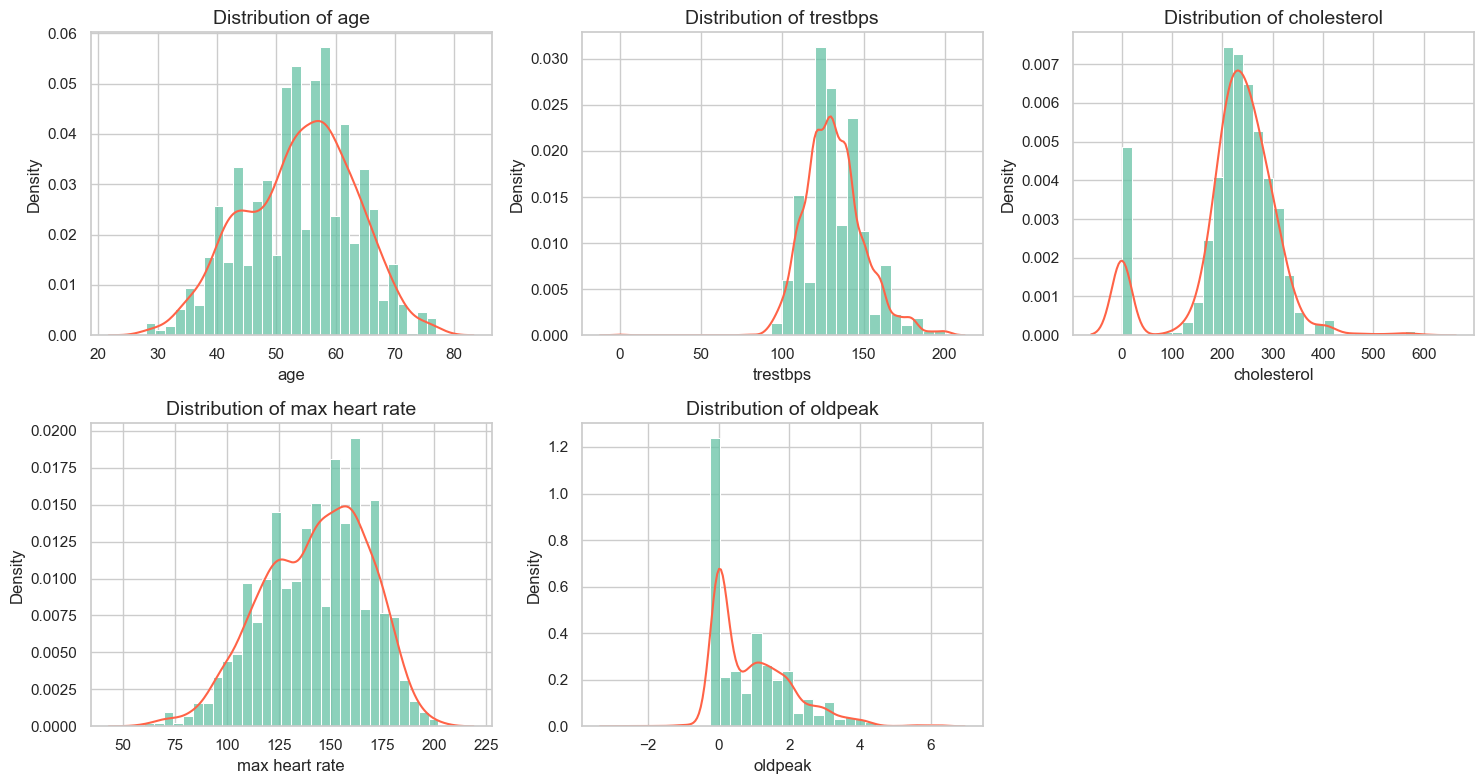

In [129]:
# Histograms and KDE for continuous variables
if len(continuous_cols) == 0:
    print("No continuous columns to plot.")
else:
    n = len(continuous_cols)
    ncols = 3
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows))
    axes = axes.flatten() if n > 1 else [axes]

    for i, col in enumerate(continuous_cols):
        ax = axes[i]
        sns.histplot(df[col].dropna(), ax=ax, bins=30, stat="density")
        sns.kdeplot(df[col].dropna(), ax=ax, color="tomato")
        ax.set_title(f"Distribution of {col}")
        ax.set_xlabel(col)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


### Frequency Tables for Categorical Variables — Explanation
- **What this does**: Lists counts for each category, including missing values if any.
- **Why it matters**: Identifies rare or dominant categories that may require regrouping or special encoding. Also surfaces data-entry anomalies (unexpected categories) before modeling.
- **Notes to summarize after running**:
  - Categories with very low frequency to consider merging: [fill]
  - Any unexpected category codes detected: [fill]


In [138]:
# Frequency tables for categorical variables
if len(categorical_cols) == 0:
    print("No categorical columns detected.")
else:
    for col in categorical_cols + ([TARGET_COL] if TARGET_COL in df.columns else []):
        print(f"\nVALUE COUNTS FOR '{col}'")
        _vc = df[col].value_counts(dropna=False).sort_index()
        _table_df = _vc.rename_axis(col).reset_index(name='count')
        _table_df['percent'] = (_table_df['count'] / _table_df['count'].sum() * 100).round(2)
        _table = _table_df.style.hide(axis='index').format({'percent': '{:.2f}%'})
        display(_table)



VALUE COUNTS FOR 'sex'


sex,count,percent
0,465,26.38%
1,1298,73.62%



VALUE COUNTS FOR 'Chest pain type'


Chest pain type,count,percent
0,23,1.30%
1,136,7.71%
2,344,19.51%
3,506,28.70%
4,754,42.77%



VALUE COUNTS FOR 'fasting blood sugar'


fasting blood sugar,count,percent
0,1424,80.77%
1,339,19.23%



VALUE COUNTS FOR 'resting ecg'


resting ecg,count,percent
0,966,54.79%
1,187,10.61%
2,610,34.60%



VALUE COUNTS FOR 'exercise angina'


exercise angina,count,percent
0,1114,63.19%
1,649,36.81%



VALUE COUNTS FOR 'ST slope'


ST slope,count,percent
0,143,8.11%
1,796,45.15%
2,725,41.12%
3,99,5.62%



VALUE COUNTS FOR 'target'


target,count,percent
0,725,41.12%
1,918,52.07%
2,120,6.81%


### Bar Charts for Categorical Variables — Explanation
- **What this does**: Plots count distributions for each categorical variable and for `target` if present.
- **Why it matters**: Helps reveal class imbalance (critical for evaluation metrics and resampling) and dominant categories. This informs encoding strategies (one-hot vs ordinal), grouping rare categories, and potential interaction features.
- **Notes to summarize after running**:
  - Any severe imbalance in `target`: [fill]
  - Categorical variables with highly skewed distributions: [fill]


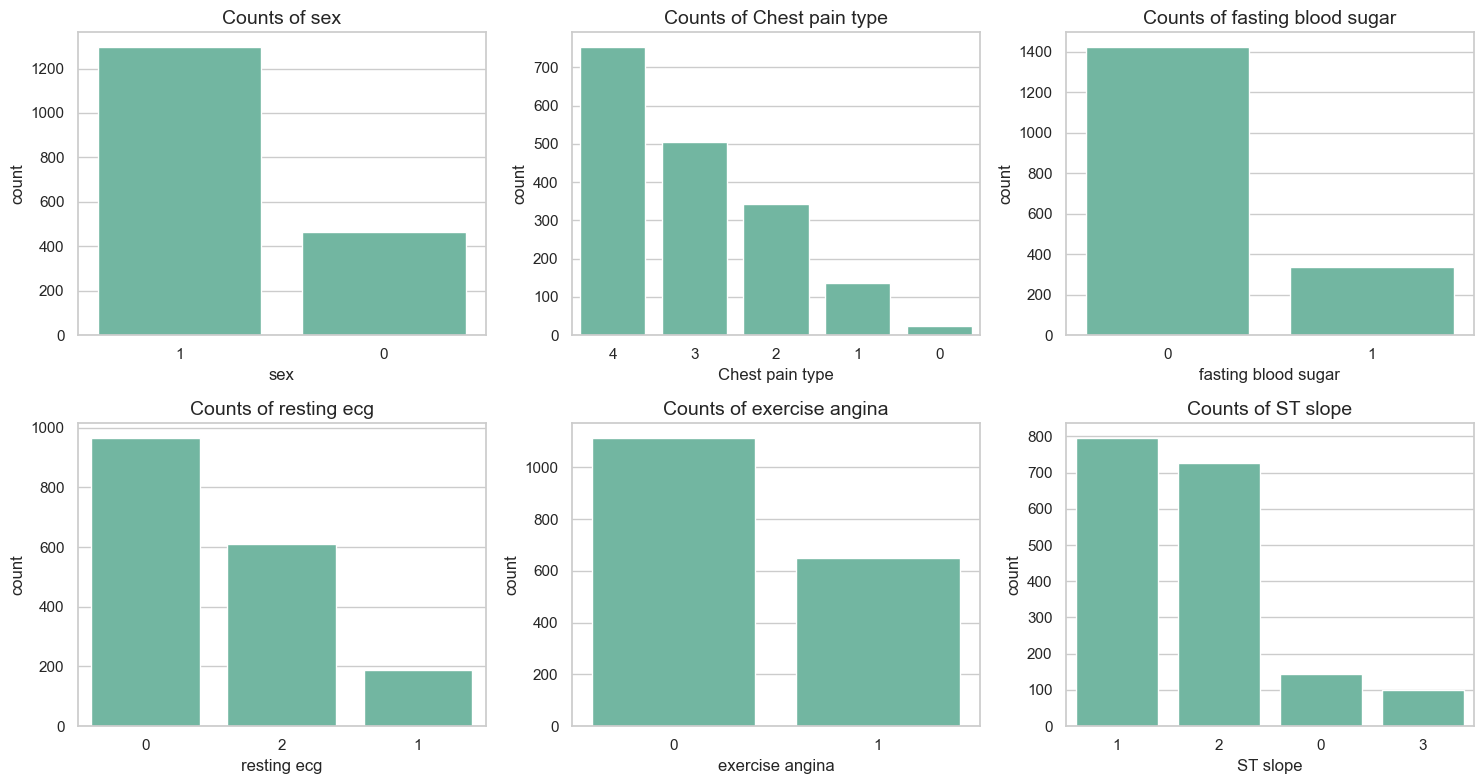

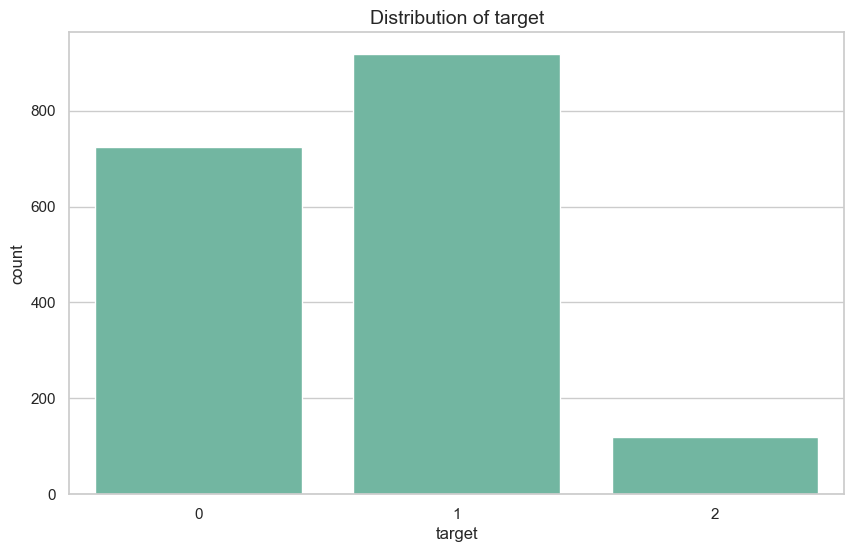

In [131]:

# Bar charts for categorical variables
if len(categorical_cols) == 0:
    print("No categorical columns to plot.")
else:
    n = len(categorical_cols)
    ncols = 3
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows))
    axes = axes.flatten() if n > 1 else [axes]

    for i, col in enumerate(categorical_cols):
        ax = axes[i]
        order = df[col].value_counts().index
        sns.countplot(data=df, x=col, order=order, ax=ax)
        ax.set_title(f"Counts of {col}")
        ax.set_xlabel(col)
        ax.set_ylabel('count')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
    
    # If target exists and is categorical/numeric small-cardinality, show its distribution
if TARGET_COL in df.columns:
    plt.figure()
    sns.countplot(data=df, x=TARGET_COL)
    plt.title(f"Distribution of {TARGET_COL}")
    plt.show()


### Data Quality Summary — Explanation
- **What this does**: Aggregates key checks (missingness, duplicates, plausible ranges, outlier rates, and class balance) and outputs a heuristic verdict.
- **Why it matters**: Gives a concise, defendable statement for the report/presentation on whether the dataset is “clean enough” for modeling, and points to specific issues to fix if not.
- **Interpreting the verdict**:
  - `CLEAN_ENOUGH`: Proceed to modeling; keep monitoring during validation.
  - `MOSTLY_CLEAN_WITH_OUTLIERS`: Consider capping/winsorizing or robust scalers; tree-based models are less sensitive.
  - `NEEDS_ATTENTION`: Address missing/duplicates/implausible ranges before modeling.
- **Notes to summarize after running**:
  - Verdict: [fill]
  - Any flagged columns or imbalances: [fill]
  - Planned actions (if any): [fill]


In [132]:
# Data Quality Summary (auto-check)
summary = {}

# Missing and duplicates
missing_counts = df.isna().sum()
summary['missing_total'] = int(missing_counts.sum())
summary['missing_columns'] = {c: int(missing_counts[c]) for c in df.columns if missing_counts[c] > 0}
summary['duplicates'] = int(df.duplicated().sum())

# Type detection
continuous_cols, categorical_cols = detect_column_types(df, target_col=TARGET_COL)
summary['continuous_cols'] = continuous_cols
summary['categorical_cols'] = categorical_cols

# Plausibility checks (domain-informed heuristics; adjust to your schema)
plausible_flags = []
if 'age' in df.columns:
    plausible_flags.append(df['age'].between(18, 100, inclusive='both').all())
if 'trestbps' in df.columns:
    plausible_flags.append((df['trestbps'] > 0).all())
if 'cholesterol' in df.columns:
    plausible_flags.append((df['cholesterol'] > 0).all())
# if 'oldpeak' in df.columns:
#     plausible_flags.append((df['oldpeak'] >= 0).all())
if 'max heart rate' in df.columns:
    plausible_flags.append((df['max heart rate'] > 0).all())
summary['plausible_ranges_pass'] = all(plausible_flags) if plausible_flags else None

# Outlier rate (IQR) quick flag
outlier_rates = {}
for col in continuous_cols:
    s = df[col].dropna()
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    rate = float(((s < lower) | (s > upper)).mean())
    outlier_rates[col] = round(rate, 4)
summary['outlier_rates'] = outlier_rates

# Target balance (if exists)
if TARGET_COL in df.columns:
    vc = df[TARGET_COL].value_counts(normalize=True)
    summary['target_balance'] = {int(k): round(float(v), 4) for k, v in vc.items()}

# Overall verdict (heuristic)
def verdict_from_summary(s):
    if s['missing_total'] == 0 and s['duplicates'] == 0 and (s['plausible_ranges_pass'] in [True, None]):
        # outliers allowed if low or clinically plausible
        hi_outliers = [c for c, r in s['outlier_rates'].items() if r > 0.1]
        if len(hi_outliers) == 0:
            return 'CLEAN_ENOUGH'
        return 'CONTAINING_[OUTLIERS = {s["outlier_rates"]}]'
    return f'CONTAINING_[MISSING = {s["missing_total"]} or DUPLICATES = {s["duplicates"]} or PLAUSIBLE_RANGES_PASS = {s["plausible_ranges_pass"]}]'
summary['verdict'] = verdict_from_summary(summary)

print('Data Quality Summary:')
for k, v in summary.items():
    print(f"- {k}: {v}")

Data Quality Summary:
- missing_total: 0
- missing_columns: {}
- duplicates: 272
- continuous_cols: ['age', 'trestbps', 'cholesterol', 'max heart rate', 'oldpeak']
- categorical_cols: ['sex', 'Chest pain type', 'fasting blood sugar', 'resting ecg', 'exercise angina', 'ST slope']
- plausible_ranges_pass: False
- outlier_rates: {'age': 0.0, 'trestbps': 0.0312, 'cholesterol': 0.118, 'max heart rate': 0.0023, 'oldpeak': 0.0113}
- target_balance: {1: 0.5207, 0: 0.4112, 2: 0.0681}
- verdict: CONTAINING_[MISSING = 0 or DUPLICATES = 272 or PLAUSIBLE_RANGES_PASS = False]


In [133]:
# # CHECK for the plausibility violations
# viol_masks = {
#   "age_out_of_range": ~df["age"].between(18, 100, inclusive="both"),
#   "trestbps_nonpositive": df["trestbps"] <= 0,
#   "cholesterol_nonpositive": df["cholesterol"] <= 0,
#   "oldpeak_negative": df["oldpeak"] < 0,
#   "max_hr_nonpositive": df["max heart rate"] <= 0,
# }

# # Đếm số dòng vi phạm theo từng rule
# counts = {k: int(m.sum()) for k, m in viol_masks.items()}
# print(counts)

# # In ra một vài dòng vi phạm cho từng rule (kèm số dòng trong CSV)
# def show_examples(mask, cols, n=10):
#   subset = df.loc[mask, cols].copy()
#   subset.insert(0, "csv_line", subset.index + 2)  # +2: 1 dòng header + index bắt đầu từ 0
#   return subset.head(n)

# cols = ["age", "trestbps", "cholesterol", "oldpeak", "max heart rate"]

# print("\n== trestbps_nonpositive ==")
# display(show_examples(viol_masks["trestbps_nonpositive"], cols))

# print("\n== cholesterol_nonpositive ==")
# display(show_examples(viol_masks["cholesterol_nonpositive"], cols))

# print("\n== oldpeak_negative ==")
# display(show_examples(viol_masks["oldpeak_negative"], cols))

### Boxplots by Target — Explanation
- **What this does**: For each continuous variable, draws a boxplot grouped by `target` (e.g., cholesterol by presence/absence of heart attack). This visualizes distribution shifts and potential differences in medians/spreads between classes.
- **Why it matters**: Significant distribution differences suggest predictive signal. This directly informs feature selection and helps prioritize variables for advanced models (e.g., XGBoost handles non-linear thresholds; strong separations might also suit simple splits).
- **Notes to summarize after running**:
  - Variables showing clear separation across `target`: [fill]
  - Consider candidate thresholds or transformations highlighted by the boxplots.


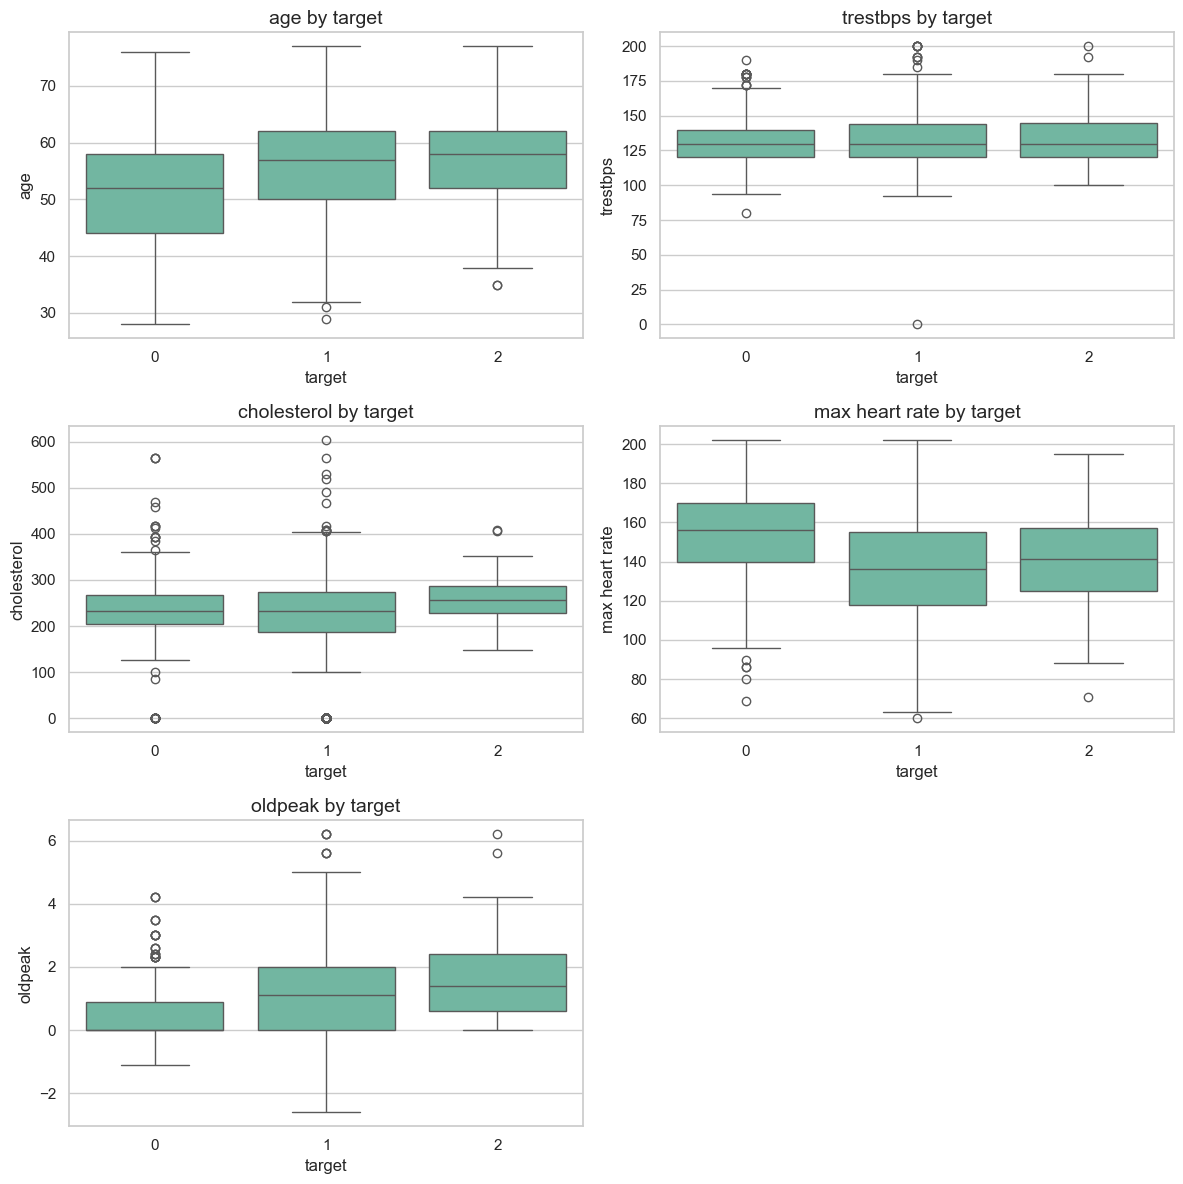

In [134]:
# Boxplots by target (e.g., cholesterol vs target)
if TARGET_COL in df.columns and TARGET_COL in df.select_dtypes(include=[np.number]).columns and df[TARGET_COL].nunique() <= 10:
    if len(continuous_cols) == 0:
        print("No continuous columns to plot.")
    else:
        n = len(continuous_cols)
        ncols = 2
        nrows = (n + ncols - 1) // ncols
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 4*nrows))
        axes = axes.flatten() if n > 1 else [axes]

        for i, col in enumerate(continuous_cols):
            ax = axes[i]
            sns.boxplot(data=df, x=TARGET_COL, y=col, ax=ax)
            ax.set_title(f"{col} by {TARGET_COL}")
            ax.set_xlabel(TARGET_COL)
            ax.set_ylabel(col)

        for j in range(i + 1, len(axes)):
            axes[j].axis('off')

        plt.tight_layout()
        plt.show()
else:
    print("Target column not suitable for grouping boxplots (missing/not numeric/too many classes).")


### IQR Outlier Summary — Explanation
- **What this does**: Uses the Interquartile Range (IQR) rule to flag potential outliers in each continuous variable and reports bounds and percentages.
- **Why it matters**: Outliers can skew means, inflate variance, and mislead models like Logistic Regression and k-NN. Knowing where they occur informs robust preprocessing (winsorization, transformations, or tree-based models less sensitive to outliers).
- **Notes to summarize after running**:
  - Variables with highest outlier percentages: [fill]
  - Consider handling method: cap at bounds, log-transform, or retain if clinically plausible.


In [135]:
# IQR-based outlier detection summary for continuous variables

def iqr_outlier_flags(series: pd.Series, k: float = 1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (series < lower) | (series > upper), lower, upper

if len(continuous_cols) == 0:
    print("No continuous columns for outlier analysis.")
else:
    rows = []
    for col in continuous_cols:
        flags, lower, upper = iqr_outlier_flags(df[col].dropna())
        outlier_count = int(flags.sum())
        rows.append({
            'column': col,
            'outliers': outlier_count,
            'outliers_pct': round(outlier_count / df[col].dropna().shape[0] * 100, 2),
            'lower_bound': round(lower, 2),
            'upper_bound': round(upper, 2)
        })
    outlier_table = pd.DataFrame(rows).sort_values('outliers', ascending=False)
    display(outlier_table)


,column,outliers,outliers_pct,lower_bound,upper_bound
2,cholesterol,208,11.80,88.75,382.75
1,trestbps,55,3.12,90.00,170.00
4,oldpeak,20,1.13,-2.40,4.00
3,max heart rate,4,0.23,69.50,217.50
0,age,0,0.00,26.00,82.00


### Correlation Matrix and Heatmap — Explanation
- **What this does**: Computes the Pearson correlation among all numeric features and visualizes it as a heatmap. This reveals linear relationships between variables and with the `target` (if numeric/binary).
- **Why it matters**: Strong correlations with `target` highlight promising predictors for the modeling stage (feature selection/importance). High correlations between features indicate potential multicollinearity, guiding regularization (e.g., L1/L2), feature grouping, or dimensionality reduction before models like Logistic Regression.
- **Notes to summarize after running**:
  - Top 3 absolute correlations with `target`: [fill after running]
  - Notable multicollinearity pairs (|r| > 0.8): [fill]
  - Potential next steps: remove/reduce collinearity, engineer interaction terms, or consider tree-based models robust to correlation (e.g., XGBoost).


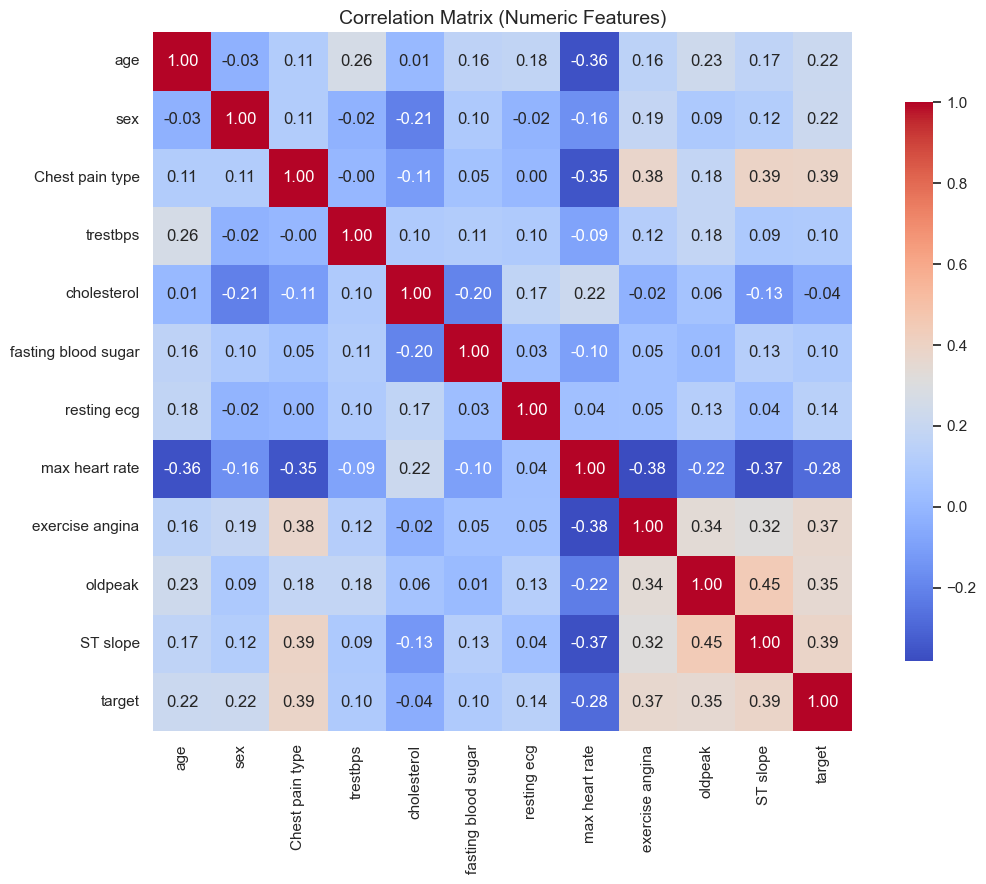

In [136]:
# Correlation matrix and heatmap (numeric features)
num_df = df.select_dtypes(include=[np.number])
if num_df.shape[1] <= 1:
    print("Not enough numeric columns for correlation analysis.")
else:
    corr = num_df.corr(numeric_only=True)
    plt.figure(figsize=(12, 9))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={'shrink': .8})
    plt.title('Correlation Matrix (Numeric Features)')
    plt.tight_layout()
    plt.show()


### Integrity Audit — Explanation
- **What this does**: Summarizes column dtypes; flags zero-variance columns; near-constant columns (≥99% one value); binary-like numeric columns (exactly two unique values); and leading/trailing whitespace in string columns.
- **Why it matters**: Ensures data is well-typed and modeling-ready, surfaces degenerate features that add no signal, catches categorical/text cleanliness issues that can fragment categories or cause errors, and clarifies which numeric columns are actually binary encodings.
- **Notes to summarize after running**:
  - `zero_variance_cols`: [fill]
  - `near_constant_cols`: [fill]
  - `binary_like_numeric`: [fill]
  - `string_cols_with_whitespace`: [fill]
  - Any dtype adjustments planned: [fill]



In [137]:
# Integrity audit: dtypes, zero-variance, binary-like checks, whitespace
report = {}

# dtypes
report['dtypes'] = df.dtypes.astype(str).to_dict()

# zero-variance / constant columns
zero_var = [c for c in df.columns if df[c].nunique(dropna=False) <= 1]
report['zero_variance_cols'] = zero_var

# near-constant (>= 99% same value)
near_constant = {}
for c in df.columns:
    top_freq = df[c].value_counts(dropna=False, normalize=True).head(1)
    if not top_freq.empty and float(top_freq.iloc[0]) >= 0.99:
        near_constant[c] = round(float(top_freq.iloc[0]), 4)
report['near_constant_cols'] = near_constant

# binary-like numeric columns (only two unique values)
binary_like = [c for c in df.select_dtypes(include=[np.number]).columns if df[c].nunique(dropna=True) == 2]
report['binary_like_numeric'] = binary_like

# whitespace in string columns
whitespace_cols = []
for c in df.select_dtypes(include=['object']).columns:
    if df[c].astype(str).str.contains(r'^\s+|\s+$', regex=True).any():
        whitespace_cols.append(c)
report['string_cols_with_whitespace'] = whitespace_cols

print('Integrity audit:')
for k, v in report.items():
    print(f"- {k}: {v}")



Integrity audit:
- dtypes: {'age': 'int64', 'sex': 'int64', 'Chest pain type': 'int64', 'trestbps': 'int64', 'cholesterol': 'int64', 'fasting blood sugar': 'int64', 'resting ecg': 'int64', 'max heart rate': 'int64', 'exercise angina': 'int64', 'oldpeak': 'float64', 'ST slope': 'int64', 'target': 'int64'}
- zero_variance_cols: []
- near_constant_cols: {}
- binary_like_numeric: ['sex', 'fasting blood sugar', 'exercise angina']
- string_cols_with_whitespace: []
